In [1]:
import numpy as np

import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
from scipy.special import logsumexp
from scipy.sparse import csr_matrix

sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

from ecoli.processes.metabolism_redux import NetworkFlowModel, FlowResult
from convex_kinetics_new import ConvexKineticsNew, BiochemicalReactionNetwork

In [2]:
# jupyter autoreload modules

%load_ext autoreload

# Import simulation output

Before running this, run a sim in ecoli/experiments/metabolism_redux_sim.py with -n 2 to generate a simulation output. This is necessary to replicate the simulation environment. Use the default .json config.

In [3]:
time = '10'
date = '2024-04-27'
experiment = 'convex_kinetics'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

In [4]:
output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [5]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [6]:
stoichiometry = agent['ecoli-metabolism-redux-classic'].stoichiometry
process_rxn_names = agent['ecoli-metabolism-redux-classic'].reaction_names
process_met_names = agent['ecoli-metabolism-redux-classic'].metabolite_names
exchange_met_names = agent['ecoli-metabolism-redux-classic'].exchange_molecules
homeostatic_met_names = agent['ecoli-metabolism-redux-classic'].homeostatic_metabolites


# get indices of 
# maintenance_reaction = agent['ecoli-metabolism-redux-classic'].model.maintenance_reaction
# stoichiometry["maintenance_reaction"] = maintenance_reaction

bad_rxns = ["RXN-12440", "TRANS-RXN-121", "TRANS-RXN-300", "TRANS-RXN-8", "R15-RXN-MET/CPD-479//CPD-479/MET.25.","DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MONOMER0-4438//MONOMER0-4438/MONOMER0-4152.71."]
# generate carbon mistake in parca, efflux/influx proton gen, iron cheating, mass gen
# for rxn in bad_rxns:
#    stoichiometry.pop(rxn, None)


In [7]:
homeostatic_met_names

array(['2-3-DIHYDROXYBENZOATE[c]', '2-KETOGLUTARATE[c]', '2-PG[c]',
       '2K-4CH3-PENTANOATE[c]', '4-AMINO-BUTYRATE[c]',
       '4-hydroxybenzoate[c]', 'ACETOACETYL-COA[c]', 'ACETYL-COA[c]',
       'ACETYL-P[c]', 'ADENINE[c]', 'ADENOSINE[c]', 'ADP-D-GLUCOSE[c]',
       'ADP[c]', 'AMP[c]', 'ANTHRANILATE[c]', 'APS[c]', 'ARG[c]',
       'ASN[c]', 'ATP[c]', 'BIOTIN[c]', 'CA+2[c]', 'CAMP[c]',
       'CARBAMYUL-L-ASPARTATE[c]', 'CARBON-DIOXIDE[c]', 'CDP[c]',
       'CHORISMATE[c]', 'CIS-ACONITATE[c]', 'CIT[c]', 'CL-[c]', 'CMP[c]',
       'CO+2[c]', 'CO-A[c]', 'CPD-12115[c]', 'CPD-12261[p]',
       'CPD-12575[c]', 'CPD-12819[c]', 'CPD-12824[c]', 'CPD-13469[c]',
       'CPD-2961[c]', 'CPD-8260[c]', 'CPD-9956[c]', 'CPD0-939[c]',
       'CTP[c]', 'CYS[c]', 'CYTIDINE[c]', 'CYTOSINE[c]', 'D-ALA-D-ALA[c]',
       'D-SEDOHEPTULOSE-7-P[c]', 'DAMP[c]', 'DATP[c]', 'DCTP[c]',
       'DEOXY-RIBOSE-5P[c]', 'DEOXYADENOSINE[c]', 'DEOXYGUANOSINE[c]',
       'DGMP[c]', 'DGTP[c]', 'DI-H-OROTATE[c]',
       '

Pandas automatically understands dicts of dicts as matrices.

# Test changing nutrient composition

In [8]:
velocities = fba["estimated_fluxes"][4]
# use reaction names to make a dict
d_velocities = {k: v for k, v in zip(process_rxn_names, velocities)}

# Filter S matrix to only include nonzero fluxes.

In [9]:
# only include nonzero fluxes in solution.velocities
nonzero_velocities = {k: v for k, v in d_velocities.items() if v != 0}
nonzero_velocities

# reaction indices with nonzero fluxes
nonzero_rxn_indices = [process_rxn_names.index(k) for k in nonzero_velocities.keys()]



In [10]:
# Use nonzero_velocities to filter S matrix
S_matrix_mask = stoichiometry[:, nonzero_rxn_indices] != 0

# remove rows of S_used that sum to zero.
nonzero_met_indices = np.where(S_matrix_mask.sum(axis=1) != 0)[0]
S_matrix = stoichiometry[:, nonzero_rxn_indices][nonzero_met_indices, :]

In [11]:
S_matrix.shape

(466, 438)

In [12]:
# sort nonzero_velocities to be in same order as S_matrix columns.
vE_dict = nonzero_velocities
vE = np.array([np.array(list(vE_dict.values()))])

dmdt = S_matrix @ vE.T

In [13]:
abs_dmdt = np.abs(dmdt)# np.max(np.array([dmdt, np.zeros(dmdt.shape)]), axis=0)
dmdt_mask = (abs_dmdt != 0).flatten()
lD = np.log(abs_dmdt[dmdt_mask]).flatten()

# Get exchange and homeostasis indices for compressed matrix

In [14]:
rxn_names = np.array(process_rxn_names)[nonzero_rxn_indices]
met_names = np.array(process_met_names)[nonzero_met_indices]

exchange_met_indices = np.array([i for i, met in enumerate(met_names) if met in exchange_met_names])
homeostatic_met_indices = np.array([i for i, met in enumerate(met_names) if met in homeostatic_met_names])
intermediate_met_indices = np.array([i for i, met in enumerate(met_names) if met not in exchange_met_names and met not in homeostatic_met_names])

# First test. Single flux set. No eQuilibrator or regulation.

In [15]:
Sd = pd.DataFrame(S_matrix, columns=[k for k in nonzero_velocities.keys()])
# Sd = pd.DataFrame(stoich_dict, dtype=np.int8).fillna(0).astype(np.int8)
# Sd = Sd.iloc[0:7, 0:2]
Sr = None

Sd.shape

(466, 438)

In [16]:
E = ConvexKineticsNew()
y_f, y_r, y_s, y_p, y_i, y_a, cd_f, cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, S_s, S_p, S_i, S_a, \
            met_s_nz, met_p_nz, met_i_nz, met_a_nz, rxn_s_nz, rxn_p_nz, rxn_i_nz, rxn_a_nz, \
            n_rxn, n_met, n_flux_set, S_s_nz, S_p_nz, S_s_mol, S_p_mol, S_b, S = E.set_up_variables(S_matrix=Sd, R_matrix=Sr, flow_data=vE, dmdt=dmdt)

Number of metabolites: 466, number of reactions: 438, number of flux sets: 1
Number of Km_s: 927, number of Km_p: 1039, number of Km_i: None, number of Km_a: None
Number of concentrations: (466, 1), number of y_f: (1, 927), number of y_r: (1, 1039)


In [17]:
C_alpha, C_beta, d_alpha, d_beta = E.construct_binding_matrix(n_rxn, S_s, S_p, S_i, S_a, Sr, met_s_nz, met_p_nz, met_i_nz, met_a_nz, rxn_s_nz, rxn_p_nz, rxn_i_nz, rxn_a_nz)

Shape of C_alpha: (1708, 927), shape of C_beta: (2294, 1039)
Shape of d_alpha: (1708,), shape of d_beta: (2294,)


In [18]:
LSE_expr, denom_expr = E.construct_kinetic_objective(vE, n_flux_set, n_rxn, C_alpha, C_beta, d_alpha, d_beta, S_s_nz, S_p_nz, S_b, y_f, y_r, y_s, y_p, cfwd, crev)

In [19]:
loss = E.create_objective_function(cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, y_s, y_p, denom_expr, dmdt)

In [20]:
constr = E.set_parameter_bounds(cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, LSE_expr, cd_f, lower_bound=-12, upper_bound=18)

In [21]:
problem = E.set_up_problem(loss, constr)


In [22]:
solution = E.solve(problem)
solution.value

/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


3107.1743847605485

(-1e-06, 1e-06)

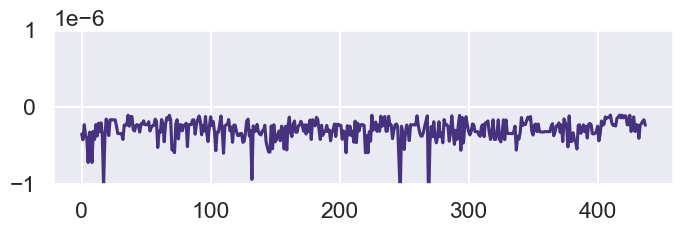

In [23]:
plt.figure(figsize=(8,2))

fit = E.evaluate_equality_fit(LSE_expr)

plt.plot(fit)

plt.ylim(-0.000001,0.000001)

In [24]:
reconstructed_vE = E.evaluate_flux_reconstruction(vE, n_flux_set, n_rxn, S_b, S_s_nz, S_p_nz, d_alpha, d_beta, 
                                                  C_alpha, C_beta, y_f, y_r, y_s, y_p, cfwd, crev)

reconstructed_dmdt = S_matrix @ reconstructed_vE.T

recon_error = (reconstructed_vE - vE).flatten()
recon_rel_error = recon_error / vE.flatten()

recon_dmdt_error = (reconstructed_dmdt - dmdt).flatten()

rxn_index_range = np.arange(n_flux_set * n_rxn)
met_index_range = np.arange(n_flux_set * n_met)


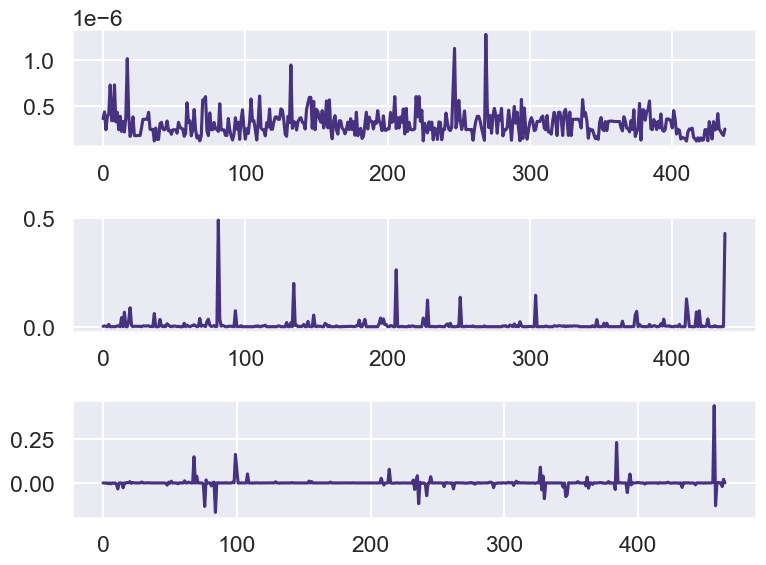

In [25]:

f, ax = plt.subplots(3, 1, figsize=(8,6))

ax[0].plot(rxn_index_range, recon_rel_error,)
ax[1].plot(rxn_index_range, recon_error,)
ax[2].plot(met_index_range, recon_dmdt_error,)

f.tight_layout()

# Solution-based recon

# Simulation-structured recon

In [26]:
cn = np.array(c.value)[:, 0]

In [27]:
B = BiochemicalReactionNetwork()

v, dm = B.forward_step(cn, S_matrix, cfwd, crev, Km_s, Km_p, Km_i, Km_a, S_s_nz, S_p_nz, S_s_mol, S_p_mol,
             S_b, C_alpha, C_beta, d_alpha, d_beta, n_rxn, met_s_nz, met_p_nz, met_i_nz, met_a_nz)

In [28]:

cn = np.array(c.value)[:, 0]



In [34]:
# simulate 100 timesteps
cur_cn = np.copy(cn)

n_step = 10000


dt = 0.00001 # timestep

# only change internal concentrations, not external
internal_mask = np.ones_like(cn)
internal_mask[exchange_met_indices] = 0

# set up constant internal drain rate
dm_exit = np.zeros_like(cn)
dm_exit[homeostatic_met_indices] = -dmdt.flatten()[homeostatic_met_indices]

cn_over_time = np.zeros((n_step, len(cn)))
v_over_time = np.zeros((n_step, len(v)))
rel_dmdt_over_time = np.zeros((n_step, len(cn)))

for i in range(n_step):
    
    print(i)
    
    v, dm = B.forward_step(cur_cn, S_matrix, cfwd, crev, Km_s, Km_p, Km_i, Km_a, S_s_nz, S_p_nz, S_s_mol, S_p_mol,
             S_b, C_alpha, C_beta, d_alpha, d_beta, n_rxn, met_s_nz, met_p_nz, met_i_nz, met_a_nz, noise=0.05)
    
    
    
    # noise in demand
    dm_exit_var = dm_exit * np.random.normal(1, 0.1, size=dm_exit.shape)
    
    # dm_tot = (dm + dm_exit) * dt
    dm_tot = (dm + dm_exit_var) * dt
    

    # set external dmdt to zero
    dm_tot[exchange_met_indices] = 0
    
    debug = np.exp(cur_cn) + dm_tot
    if np.any(debug < 0):
        print('negative concentration')
        # find metabolites with negative concentration
        neg_indices = np.where(debug < 0)[0]
        print(met_names[neg_indices])
        print(np.exp(cur_cn)[neg_indices])
        print(dm[neg_indices] * dt)
        
        break
    
    # update internal concentrations
    cur_cn = np.log(np.exp(cur_cn) + dm_tot)
    rel_dmdt_over_time[i, :] = dm_tot / np.exp(cur_cn)
    
    cn_over_time[i, :] = cur_cn
    v_over_time[i, :] = v
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

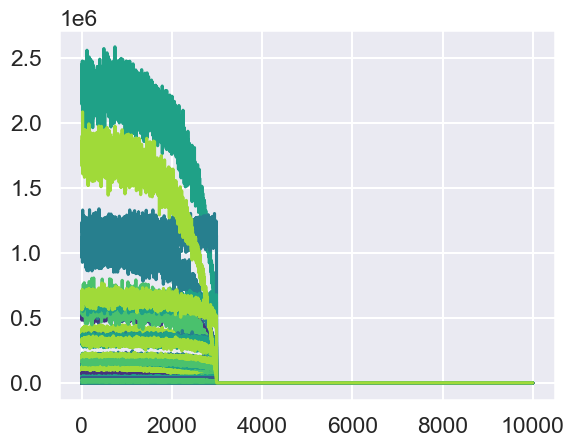

In [35]:
plt.plot(v_over_time)

In [36]:
# add met names column to cn_over_time array
overview_df = pd.DataFrame(cn_over_time.T, columns=[f'timestep_{i}' for i in range(n_step)])

# add met names column to cn_over_time array
overview_df['met'] = met_names

overview_df

,timestep_0,timestep_1,timestep_2,timestep_3,timestep_4,timestep_5,timestep_6,timestep_7,timestep_8,timestep_9,...,timestep_91,timestep_92,timestep_93,timestep_94,timestep_95,timestep_96,timestep_97,timestep_98,timestep_99,met
0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1-AMINO-PROPAN-2-ONE-3-PHOSPHATE[c]
1,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1-PALMITOYLGLYCEROL-3-PHOSPHATE[c]
2,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,10-FORMYL-THF[c]
3,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,2-3-DIHYDROXYBENZOATE[c]
4,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,2-ACETO-LACTATE[c]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,ZN+2[c]
462,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,ZN+2[p]
463,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,biotin-L-lysine-in-BCCP-dimers[c]
464,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,carboxybiotin-L-lysine-in-BCCP-dimers[c]


In [113]:
len(met_names)

466

In [30]:
(np.array([dm, np.exp(c.value[:,0]), dm / np.exp(cn), met_names]).T)[homeostatic_met_indices, :]

array([['8.999996055532733', '0.40683017863053234', '22.122242961002623',
        '2-3-DIHYDROXYBENZOATE[c]'],
       ['26.97229881907697', '0.253530189106861', '106.38693133190681',
        '2-KETOGLUTARATE[c]'],
       ['6.98060065053869', '0.07980578787906088', '87.46985445613565',
        '2-PG[c]'],
       ['10.001344345568214', '0.08367397868620037',
        '119.52753415821076', '2K-4CH3-PENTANOATE[c]'],
       ['23.000004051261662', '0.05534815134827712',
        '415.55144103250353', '4-AMINO-BUTYRATE[c]'],
       ['4.000000171645359', '0.07314155028971264', '54.688479473041184',
        '4-hydroxybenzoate[c]'],
       ['2.000000279108478', '0.010783137372267203',
        '185.47480293186408', 'ACETOACETYL-COA[c]'],
       ['76.9994111397973', '0.29541918620258495', '260.6445848340894',
        'ACETYL-COA[c]'],
       ['79.00001376624533', '0.1369406965874682', '576.892156494805',
        'ACETYL-P[c]'],
       ['-1.5105644166624188e-06', '0.02578958524220653',
        '-5.85

In [33]:
cell_volume = 3e-15

0.001 * (cell_volume * 6.022e23)

1806600.0

# Try to simulate concentration changes over time

In [34]:
# don't change external exchange concentrations
# for internal exchange concentrations, take out a small amount per timestep

